In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from IPython.display import clear_output

SCREEN_SIZE = (800, 600)
NUM_NODES = 20
NUM_EDGES = 25
TURNS = 3
GAMES = 8

#I have a reason for not just importing these, don't judge :/
def get_graph_laplacian(edges, n=NUM_NODES):
    # Create adjacency matrix
    adj_mat = np.zeros((n, n))
    for i, j in edges:
        adj_mat[i, j] = 1
        adj_mat[j, i] = 1

    # Get degree matrix
    deg_mat = np.diag(np.sum(adj_mat, axis=1))

    return deg_mat - adj_mat  # Laplacian matrix

def get_influence(graph_laplacian, config):
    """This function takes in the graph Laplacian and the previously
    selected boundary nodes as columns of a matrix with each column
    representing a different boundary node set. It returns the influence
    had by each team in the graph.

    Args:
        graph_laplacian ((n,n) ndarray): The graph Laplacian for the given graph

        config (ndarray): The previously selected boundary nodes in sequential order alternating team

    Returns:
        influence ((2,) ndarray): The influence of each team in the graph
    """

    # Get all boundary nodes for team 1 and create an n length array with 1's in those positions
    config = config.astype(int)
    team_1_nodes = config[1::2]
    team_1_bd = np.zeros(graph_laplacian.shape[0]).astype(int)
    team_1_bd[team_1_nodes] = 1

    # Create the Laplacian of the subgraph
    compliment = np.setdiff1d(np.arange(graph_laplacian.shape[0]), config)
    lsc = graph_laplacian[compliment, :][:, compliment]

    # Compute the boundary block matrix
    b = graph_laplacian[compliment, :][:, config]

    # Calculate the influence using least squares to solve the linear system
    influence_1 = np.linalg.lstsq(lsc, -b @ team_1_bd[config], rcond=None)[0].sum()

    # Add influence of each node in the specific boundary set
    influence_1 += team_1_bd.sum()

    # Calculate the influence of the other team
    influence_0 = graph_laplacian.shape[0] - influence_1

    return np.array((influence_0, influence_1))

def minimax_algorithm_opt(graph_laplacian, config, nodes_per_team=TURNS, depth=np.inf):
    """ Optimized using alpha-beta pruning.

    This function takes in the graph Laplacian, the previously
    selected boundary nodes as an iterable, and the number of nodes
    per team. It returns the best node to add to the boundary set
    using the minimax algorithm.

    Args:
        graph_laplacian ((n,n) ndarray): The graph Laplacian for
        the given graph

        config (ndarray): The previously selected boundary nodes
        in sequential order alternating team

        nodes_per_team (int): The number of nodes per team

    Returns:
        best_node (int): The best node to add to the boundary set
    """

    def minimax_recursive_step(config, depth, alpha, beta):

        if type(config) is not np.ndarray:
            config = np.array(config)

        turn = config.shape[0] % 2  # 0 for maximizing team, 1 for minimizing team

        if depth == 0 or config.shape[0] == nodes_per_team * 2:
            return get_influence(graph_laplacian, config.astype(int))[0], None

        nodes_remaining = np.setdiff1d(np.arange(graph_laplacian.shape[0]), config)

        if turn == 0:  # Maximizing team
            value = -np.inf
            best_node = None
            for node in nodes_remaining:
                new_value, _ = minimax_recursive_step(np.append(config, node), depth - 1, alpha, beta)
                # if the value is updated, update the best move
                if value < new_value:
                    value = new_value
                    best_node = node
                # Alpha-Beta Pruning
                if value > beta:
                    break
                alpha = max(alpha, value)
            return value, best_node

        if turn == 1:  # Minimizing team
            value = np.inf
            best_node = None
            for node in nodes_remaining:
                new_value, _ = minimax_recursive_step(np.append(config, node), depth - 1, alpha, beta)
                # if the value is updated, update the best move
                if value > new_value:
                    value = new_value
                    best_node = node
                # Alpha-Beta Pruning
                if value < alpha:
                    break
                beta = min(beta, value)
            return value, best_node

    return minimax_recursive_step(config, depth, -np.inf, np.inf)[1]

def gui_minimax_algorithm_opt(graph_laplacian, config, depth=3):
    """ Optimized using alpha-beta pruning.

    This function takes in the graph Laplacian, the previously
    selected boundary nodes as an iterable, and the number of nodes
    per team. It returns the best node to add to the boundary set
    using the minimax algorithm.

    Args:
        graph_laplacian ((n,n) ndarray): The graph Laplacian for
        the given graph

        config (ndarray): The previously selected boundary nodes
        in sequential order alternating team

        nodes_per_team (int): The number of nodes per team

    Returns:
        best_node (int): The best node to add to the boundary set
    """

    def minimax_recursive_step(config, depth, alpha, beta):

        if type(config) is not np.ndarray:
            config = np.array(config)

        turn = config.shape[0] % 2  # 0 for maximizing team, 1 for minimizing team

        if depth == 0:
            return get_influence(graph_laplacian, config.astype(int))[0], None

        nodes_remaining = np.setdiff1d(np.arange(graph_laplacian.shape[0]), config)

        if turn == 0:  # Maximizing team
            value = -np.inf
            best_node = None
            for node in nodes_remaining:
                new_value, _ = minimax_recursive_step(np.append(config, node), depth - 1, alpha, beta)
                # if the value is updated, update the best move
                if value < new_value:
                    value = new_value
                    best_node = node
                # Alpha-Beta Pruning
                if value > beta:
                    break
                alpha = max(alpha, value)
            return value, best_node

        if turn == 1:  # Minimizing team
            value = np.inf
            best_node = None
            for node in nodes_remaining:
                new_value, _ = minimax_recursive_step(np.append(config, node), depth - 1, alpha, beta)
                # if the value is updated, update the best move
                if value > new_value:
                    value = new_value
                    best_node = node
                # Alpha-Beta Pruning
                if value < alpha:
                    break
                beta = min(beta, value)
            return value, best_node

    return minimax_recursive_step(config, depth, -np.inf, np.inf)[1]

## Speed Measurements

#### Set Up

In [3]:
graphs = [nx.gnm_random_graph(NUM_NODES, NUM_EDGES) for _ in range(GAMES)]    
#graphs = [nx.random_geometric_graph(NUM_NODES, 0.27) for _ in range(GAMES)]

def create_figure(graph_count=GAMES):
    mosaic = []
    for game in range(graph_count):
        if game % 4 == 0:
            mosaic.append([])
        mosaic[int(game / 4)].append(f"Game #{game + 1}")

    if graph_count % 4 != 0:
        for _ in range(4 - graph_count % 4):
            mosaic[int(graph_count / 4)].append(".")
    fig, ax_dict = plt.subplot_mosaic(mosaic, figsize=(14, 3 * np.ceil(GAMES / 4)))
    return fig, ax_dict

#fig, ax_dict = create_figure()
#fig.suptitle("Graphs to Be Used")
#for game in range(GAMES):
#    ax = ax_dict[f"Game #{game + 1}"]
#    ax.set_title(f"Game #{game + 1}", fontsize="small")
#    nx.draw_kamada_kawai(graphs[game], node_size=70, with_labels=True, font_size=6, node_color="blue", font_color="white", ax=ax)

def speed_measure(alg1, alg2, depth1=3, depth2=3, title="Simulation"):
    fig, ax_dict = create_figure()
    fig.suptitle(title)

    game_time_sum = 0
    turn_time_sum = [0 for _ in range(TURNS * 2)]
    game_counter = 1
    while game_counter <= GAMES:
        glp = get_graph_laplacian(graphs[game_counter - 1].edges)
        move_counter = 0
        config = []
        remaining_nodes = [i for i in range(NUM_NODES)]
        node_colors = ["gray" for _ in range(NUM_NODES)]
        pick_order = {}
        game_time = dt.now()
        while move_counter < TURNS * 2:
            turn_time = dt.now()
            if move_counter % 2 == 0:
                pick = alg1(glp, config, depth=depth1)
                node_colors[pick] = "red"
            else:
                pick = alg2(glp, config, depth=depth2)
                node_colors[pick] = "blue"
            turn_time = dt.now() - turn_time
            clear_output(wait=True)
            print(f"Game #{game_counter}, Turn {move_counter + 1}: {turn_time.total_seconds()} seconds")
            turn_time_sum[move_counter] += turn_time.total_seconds()
            pick_order[pick] = move_counter + 1
            move_counter += 1
            remaining_nodes.remove(pick)
            config.append(pick)

        game_time = dt.now() - game_time
        game_time_sum += game_time.total_seconds()
        
        results = get_influence(glp, np.array(config))
        ax = ax_dict[f"Game #{game_counter}"]
        ax.set_title(f"Game #{game_counter}: T{np.argmax(results)} - {np.round(max(results[0], results[1]) * 100 / NUM_NODES, 3)}% ({np.round(game_time.total_seconds(), 3)}s)", fontsize="small")
        nx.draw_kamada_kawai(graphs[game_counter - 1], node_size=70, labels=pick_order, font_size=6, node_color=node_colors, font_color="white", ax=ax)
        
        game_counter += 1

    clear_output(wait=True)
    print(f"Average Game Time: {np.round(game_time_sum / GAMES, 3)} seconds")
    print(f"Average Turn Times:")
    print(f"Turn 1: {np.round(turn_time_sum[0] / GAMES, 3)} seconds")
    print(f"Turn 2: {np.round(turn_time_sum[1] / GAMES, 3)} seconds")
    print(f"Turn 3: {np.round(turn_time_sum[2] / GAMES, 3)} seconds")
    print(f"Turn 4: {np.round(turn_time_sum[3] / GAMES, 3)} seconds")
    print(f"Turn 5: {np.round(turn_time_sum[4] / GAMES, 3)} seconds")
    print(f"Turn 6: {np.round(turn_time_sum[5] / GAMES, 3)} seconds")
    plt.show()

def depth_measure(alg1, alg2, depth_list1=[i + 1 for i in range(TURNS * 2)], depth_list2=[i + 1 for i in range(TURNS * 2)], title="Untitled Sim", graph_index=0):
    fig, ax_dict = create_figure(len(depth_list1))
    fig.suptitle(title)

    game_time_sum = 0
    turn_time_sum = [0 for _ in range(TURNS * 2)]
    game_counter = 1
    glp = get_graph_laplacian(graphs[graph_index].edges)
    while game_counter <= len(depth_list1):
        move_counter = 0
        config = []
        remaining_nodes = [i for i in range(NUM_NODES)]
        node_colors = ["gray" for _ in range(NUM_NODES)]
        pick_order = {}
        game_time = dt.now()
        while move_counter < TURNS * 2:
            turn_time = dt.now()
            if move_counter % 2 == 0:
                pick = alg1(glp, config, depth=depth_list1[game_counter - 1])
                node_colors[pick] = "red"
            else:
                pick = alg2(glp, config, depth=depth_list2[game_counter - 1])
                node_colors[pick] = "blue"
            turn_time = dt.now() - turn_time
            clear_output(wait=True)
            print(f"Game #{game_counter}, Turn {move_counter + 1}: {turn_time.total_seconds()} seconds")
            turn_time_sum[move_counter] += turn_time.total_seconds()
            pick_order[pick] = move_counter + 1
            move_counter += 1
            remaining_nodes.remove(pick)
            config.append(pick)

        game_time = dt.now() - game_time
        game_time_sum += game_time.total_seconds()
        
        results = get_influence(glp, np.array(config))
        ax = ax_dict[f"Game #{game_counter}"]
        ax.set_title(f"D{depth_list1[game_counter - 1]} v D{depth_list2[game_counter - 1]}: T{np.argmax(results)} - {np.round(max(results[0], results[1]) * 100 / NUM_NODES, 3)}% ({np.round(game_time.total_seconds(), 3)}s)", fontsize="small")
        nx.draw_kamada_kawai(graphs[graph_index], node_size=70, labels=pick_order, font_size=6, node_color=node_colors, font_color="white", ax=ax)
        
        game_counter += 1

def speed_depth_count(alg1, alg2, depth_list, node_count_list, title='Depth and Count vs Speed'):
    fig, axd = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={'projection': '3d'})
    fig.suptitle(title)
    fig.subplots_adjust(wspace=0.25)
    speed_ax = axd[0]
    score_ax = axd[1]
    speed_ax.set_title("Speed of Games")
    score_ax.set_title("Score of Games")
    ls = plt.matplotlib.colors.LightSource(azdeg=30, altdeg=45)

    game_data = []
    for d in depth_list:
        for n in node_count_list:
            G = nx.gnm_random_graph(n, n) #for now m = n
            glp = get_graph_laplacian(G.edges, n)
            move_counter = 0
            config = []
            game_time = dt.now()
            while move_counter < TURNS * 2:
                if move_counter % 2 == 0:
                    pick = alg1(glp, config, depth=d)
                else:
                    pick = alg2(glp, config, depth=d)
                config.append(pick)
                move_counter += 1
            game_time = dt.now() - game_time
            results = get_influence(glp, np.array(config))
            game_data.append([np.argmax(results), max(results) / n, game_time.total_seconds()])

    X, Y = np.meshgrid(depth_list, node_count_list)
    xpos = X.ravel() - 0.25  # Shift by half of the bar width (0.5)
    ypos = Y.ravel() - 2.5   # Shift by half of the bar height (5)

    colors = ['red' if game_data[i][0] == 0 else 'blue' for i in range(len(depth_list) ** 2)]

    speed_ax.bar3d(xpos, ypos, np.zeros_like(X).ravel(), 0.5, 5, [game_data[i][2] for i in range(len(depth_list) ** 2)], shade=True, zsort='average', lightsource=ls, color=colors)
    speed_ax.set_xlabel("Depth", labelpad=0.5)
    speed_ax.set_ylabel("Nodes")
    speed_ax.set_zlabel("Time (seconds)", rotation=90, labelpad=1.5)
    speed_ax.invert_xaxis()
    speed_ax.set_xticks(depth_list)
    speed_ax.set_yticks(node_count_list)
    speed_ax.set_box_aspect((1, 1, 1.1))

    score_ax.bar3d(xpos, ypos, np.zeros_like(X).ravel(), 0.5, 5, [game_data[i][1] for i in range(len(depth_list) ** 2)], shade=True, zsort='average', lightsource=ls, color=colors)
    score_ax.set_xlabel("Depth", labelpad=0.5)
    score_ax.set_ylabel("Nodes")
    score_ax.set_zlabel("Score (%)", rotation=90, labelpad=1.5) 
    score_ax.invert_xaxis()
    score_ax.set_xticks(depth_list)
    score_ax.set_yticks(node_count_list)
    score_ax.set_box_aspect((1, 1, 1.2))



#### Speed as Depth and Node Count Varies

KeyboardInterrupt: 

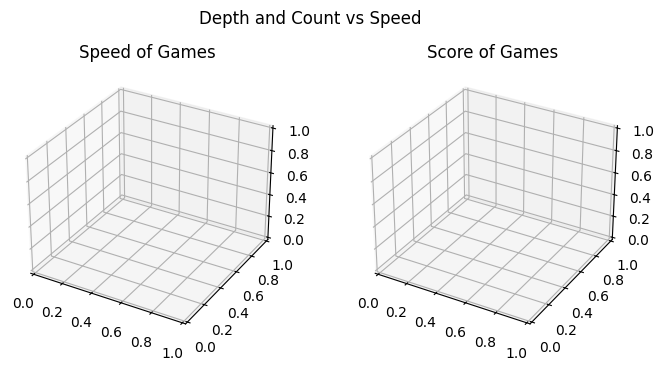

In [4]:
speed_depth_count(minimax_algorithm_opt, minimax_algorithm_opt, [1, 2, 3, 4], [10, 20, 30, 40])

#### Minimax vs Minimax

In [ ]:
speed_measure(minimax_algorithm_opt, minimax_algorithm_opt, depth1=np.inf, depth2=np.inf, title="Minimax vs Minimax")

#### GUI Minimax vs GUI Minimax

In [ ]:
speed_measure(gui_minimax_algorithm_opt, gui_minimax_algorithm_opt, title="GUI Minimax vs GUI Minimax")

NameError: name 'speed_measure' is not defined

#### Minimax (depth 3) vs Minimax (depth 3)
*Note: this is NOT the same as GUI Minimax vs GUI Minimax because of the check to see if the game is over*

In [ ]:
speed_measure(minimax_algorithm_opt, minimax_algorithm_opt, depth1=3, depth2=3, title="Minimax (d=3) vs Minimax (d=3)")

#### Depth Speed Comparison

In [ ]:
graph_selection = 8
title = f"Depth Comparison - {graphs[graph_selection - 1].number_of_nodes()} nodes, {graphs[graph_selection - 1].number_of_edges()} edges"
depth_measure(minimax_algorithm_opt, minimax_algorithm_opt, title=title, graph_index=graph_selection - 1)